In [1]:
# Import raw data from Excel
import pandas as pd
filepath = 'C:/Users/PXY/Desktop/Orange_week.xlsx';
sheetname = 'main'
df = pd.read_excel ( filepath, sheet_name = sheetname );
print (df)

     Year    Week  Cases  Rainfalls  No.of Raindays  Max. temperature  \
0    2010   week1    NaN        NaN             NaN               NaN   
1    2010   week2    NaN        NaN             NaN               NaN   
2    2010   week3    NaN        NaN             NaN               NaN   
3    2010   week4    NaN      286.0            22.0         32.883871   
4    2010   week5    NaN        NaN             NaN               NaN   
5    2010   week6    NaN        NaN             NaN               NaN   
6    2010   week7    NaN        NaN             NaN               NaN   
7    2010   week8   36.0      241.8            11.0         34.385714   
8    2010   week9   65.0        NaN             NaN               NaN   
9    2010  week10   46.0        NaN             NaN               NaN   
10   2010  week11   31.0        NaN             NaN               NaN   
11   2010  week12   27.0      191.8            14.0         34.338710   
12   2010  week13   40.0        NaN             NaN

"std_value = data['Cases'].std()\nmean_value = data['Cases'].mean()\nmax_boundary = mean_value + std_value\nmin_boundary = max( mean_value - std_value, 0 )\nindex = ( data['Cases'] > max_boundary ) | ( data['Cases'] < min_boundary )\n\nimport numpy as np\ndata.loc[index,'Cases'] = np.nan\ndata['Cases'].bfill( inplace = True );\ndata['Cases'].ffill( inplace = True );\n\nplt.figure()\nplt.plot_date(data['Date'], data['Cases'], linestyle = 'solid', marker = 'None' )\n"

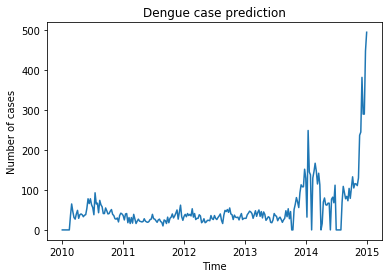

In [4]:
# Data preprocessing
# Set NaN to 0.0 for Cases & Fatality
df['Cases'].fillna( 0, inplace = True )
df['Fatality'].fillna(0, inplace = True )

# Set others to first found values
df['Rainfalls'].ffill( inplace = True );
df['Max. temperature'].ffill( inplace = True );
df['Min. temperature'].ffill( inplace = True );
df['Mean temp'].ffill( inplace = True );

# Ffill doesn't fill in the first three NaN, thus need to do another bfill
df['Rainfalls'].bfill( inplace = True );
df['Max. temperature'].bfill( inplace = True );
df['Min. temperature'].bfill( inplace = True );
df['Mean temp'].bfill( inplace = True );

# Add new column
import datetime 
date = []
for index,row in df.iterrows():
    row['Date'] = datetime.datetime.strptime( str( row['Year'])+ row['Week'] + "-1", "%Yweek%W-%w")
    date.append( row['Date'])

df['Date'] = date

# Verify if all the anomalies are gone and new column added succesfully
df.dtypes

# Create a new data frame
data = pd.DataFrame()
data['Date'] = df['Date']
data['Rainfalls'] = df['Rainfalls'];
data['Max. temperature'] = df['Max. temperature']
data['Min. temperature'] = df['Min. temperature']
data['Mean temp'] = df['Mean temp']
data['Cases'] = df['Cases']

# Since there is no case reported since 2015, drop 2015 data from time series prediction
data.drop(data.tail(52).index,inplace=True) #drop bottom 52 which is data from 2015 

# Show the data in chart
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
dates = matplotlib.dates.date2num(df['Date'])
plt.plot_date(data['Date'], data['Cases'], linestyle = 'solid', marker = 'None')
#plt.plot_date(data['Date'], data['Max. temperature'], linestyle = 'solid', marker = 'None', color = 'red')
#plt.plot_date(data['Date'], data['Min. temperature'], linestyle = 'solid', marker = 'None', color = 'green')
#plt.plot_date(data['Date'], data['Rainfalls'], linestyle = 'solid', marker = 'None', color = 'black')
#plt.plot_date(data['Date'], data['Mean temp'], linestyle = 'solid', marker = 'None', color = 'orange' )
plt.title('Dengue case prediction')
plt.xlabel('Time')
plt.ylabel('Number of cases')

# Filter anomalies by using mean+std dev or mean - std dev
'''std_value = data['Cases'].std()
mean_value = data['Cases'].mean()
max_boundary = mean_value + std_value
min_boundary = max( mean_value - std_value, 0 )
index = ( data['Cases'] > max_boundary ) | ( data['Cases'] < min_boundary )

import numpy as np
data.loc[index,'Cases'] = np.nan
data['Cases'].bfill( inplace = True );
data['Cases'].ffill( inplace = True );

plt.figure()
plt.plot_date(data['Date'], data['Cases'], linestyle = 'solid', marker = 'None' )
'''
#from scipy.signal import savgol_filter
#filtered_case = savgol_filter(data['Cases'], 11,2)
#plt.plot_date(dates,filtered_case,color ='red', linestyle = 'solid', marker= 'None')
#plt.show()

In [5]:
# Normalizing data
# This step is really useful on improving model performance
import sklearn
from sklearn.preprocessing import MinMaxScaler
cols_to_norm = [ 'Cases']
sc = MinMaxScaler();
scaled_data = data.copy()
scaled_data[cols_to_norm] = sc.fit_transform(data[cols_to_norm])
 
# Split into train and test sets",
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = scaled_data[:train_size], scaled_data.tail(test_size)

# Get the subset of the data for training
training_set = train.iloc[:, 5].values
# Define the timestep
timestep = 5

# Create input for training
import numpy as np
X_train = []
y_train =[]
for i in range(timestep, len(training_set)):
    X_train.append(training_set[i-timestep:i]);
    y_train.append(training_set[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))   

In [6]:
# Build and train the model
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

regressor = tf.keras.Sequential()

regressor.add(LSTM(units = timestep, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2) )

regressor.add(LSTM(units = timestep, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = timestep, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = timestep))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
203/203 [==============================] - 6s 30ms/sample - loss: 0.0063
Epoch 2/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0036
Epoch 3/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0022
Epoch 4/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0019
Epoch 5/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0021
Epoch 6/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0020
Epoch 7/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0019
Epoch 8/100
203/203 [==============================] - 0s 2ms/sample - loss: 0.0019
Epoch 9/100
203/203 [=======================

In [7]:
# Create test data for prediction
test_set = training_set[-timestep:]
test_set = np.concatenate(( (test.iloc[:, 5].values),test_set ) )
X_test = []

# Make prediction
for i in range(timestep, len(test) + timestep ):
    X_test.append(test_set[i-timestep:i])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_cases = regressor.predict(X_test)
predicted_cases = sc.inverse_transform(predicted_cases )


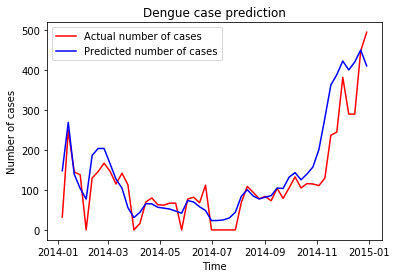

Test RMSE: 55.045


ModuleNotFoundError: No module named 'keras'

In [12]:
# Get real data
real_cases = data['Cases'].tail(test_size).values

# Visualising the results
plt.plot(data['Date'].tail(test_size),real_cases, color = 'red', label = 'Actual number of cases')
plt.plot(data['Date'].tail(test_size), predicted_cases, color = 'blue', label = 'Predicted number of cases')
plt.title('Dengue case prediction')
plt.xlabel('Time')
plt.ylabel('Number of cases')
plt.legend()
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(real_cases, predicted_cases))
print('Test RMSE: %.3f' % rmse)

# Export result to csv
fullresult = pd.DataFrame()
fullresult['Date'] = data['Date'].tail(test_size)
fullresult['Actual'] = real_cases
fullresult['Predicted'] = predicted_cases.astype(int)
fullresult.to_csv('C:/Users/PXY/Desktop/singlefeatures_result.csv');

# Visualize neural network
from tensorflow.keras.utils import plot_model
plot_model(regressor, to_file='C:/Users/PXY/Desktop/model.png')
